In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from tqdm import tqdm_notebook as tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd 'drive/My Drive/GenomicsProject/GenomicsProject'

/content/drive/My Drive/GenomicsProject/GenomicsProject


In [ ]:
%run data_prep.py "FinalModel" -motif_length 3 -window_size 100 -stride 100

Preprocessing Sequence Data...


/content/drive/My Drive/GenomicsProject/GenomicsProject/data_prep.py:119: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  seq_data = np.genfromtxt('seq_data.csv', delimiter=',', dtype=None)



Saving Sequence Data...
Loading Training Data...
Training histones shape: (720000, 100, 16)
Training outputs shape: (720000,)
Test histones shape: (80000, 100, 16)
Test outputs shape: (80000,)
Saving Training and Test Data...
Saving Complete.
Loading Submission Data...
Submission histones shape: (177032, 100, 16)
Saving Submission Data...
Saving Complete.


<Figure size 432x288 with 0 Axes>

In [ ]:
ls FinalModel

sequence_labels.pt  submission_in.pt  test_out.pt  train_out.pt
sequences.pt        test_in.pt        train_in.pt


In [ ]:
ls

 BestModel/     FinalModel/   MidSmoothInput/   motif_test4/   train.npz
 data_prep.py   input/        MidSmoothModel/   __pycache__/   train.py
 eval.npz       LongModel/    model.py          seq_data.csv  'Useless Stuff'/


In [ ]:
import argparse
import copy
import os
from glob import glob
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import traceback
from itertools import accumulate as accumulate

def get_input_grad(model, inp):
    inp.requires_grad = True
    outp = model.forward(inp)
    outp = torch.sum(outp)
    outp.backward()

def get_three_input_grad(model1, model2, model3, inp):
    inp.requires_grad = True
    outp = model1.forward(inp) + model2.forward(inp) + model3.forward(inp)
    outp = torch.sum(outp)
    outp.backward()
    

def do_input_grad(model, inp):
    get_input_grad(model,inp)

    plt.figure()
    plt.title('Histones')
    plt.imshow(inp.grad[0,1:16,:])
    #plt.colorbar()
    plt.show()

    plt.figure()
    plt.title('DNA')
    plt.imshow(inp.grad[0,16:,:])
    #plt.colorbar()
    plt.show()


def get_grad_i(model1,model2,model3,inputs,outputs,i,plot=True):

    inp_to_feed = inputs[i:i+1,:,:]
    inp_to_feed.requires_grad = True

    outp = model1.forward(inp_to_feed) + model2.forward(inp_to_feed) + model3.forward(inp_to_feed)
    outp = torch.sum(outp)
    outp.backward()

    if plot:
      plt.figure()
      plt.title(f'Gradients with repect to example {i}, out = {round(float(outputs[i]),2)}')
      plt.imshow(inp_to_feed.grad[0,:,:])
      plt.show()

    return inp_to_feed.grad[0,:,:]

def get_abs_grad_i(model1,model2,model3,inputs,outputs,i,plot=True):
    inp_to_feed = inputs[i,:,:].view((1,5,100))
    inp_to_feed.requires_grad = True

    outp = model1.forward(inp_to_feed) + model2.forward(inp_to_feed) + model3.forward(inp_to_feed)
    outp = torch.sum(outp)
    outp.backward()

    if plot:
      plt.figure()
      plt.title(f'Gradients with repect to example {i}, out = {round(float(outputs[i]),2)}')
      plt.imshow(torch.abs(inp_to_feed.grad[0,:,:]))
      plt.show()

    return torch.abs(inp_to_feed.grad[0,:,:])

In [ ]:
histone_inputs = torch.load('FinalModel/train_in.pt')
histone_outputs = torch.load('FinalModel/train_out.pt')
seq_inputs = torch.load('FinalModel/sequences.pt').permute(0,2,1)
seq_outputs = torch.load('FinalModel/sequence_labels.pt')

#real_inputs = torch.cat((histone_inputs[0,:,:],seq_inputs[0,:,:]),0).view((1,80,100))

model1 = torch.load('motif_test4/model_1_150.ptm')[0]
model2 = torch.load('motif_test4/model_2_150.ptm')[0]
model3 = torch.load('motif_test4/model_3_150.ptm')[0]
model1.eval()
model2.eval()
model3.eval()

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'model.ConvolutionalModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.n

ConvolutionalModel(
  (conv): ModuleList(
    (0): ConvBlock(
      (conv): Conv1d(80, 256, kernel_size=(3,), stride=(1,))
      (dropout): Dropout2d(p=0.2, inplace=False)
      (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ConvBlock(
      (conv): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
      (dropout): Dropout2d(p=0.2, inplace=False)
      (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ConvBlock(
      (conv): Conv1d(256, 128, kernel_size=(3,), stride=(1,))
      (dropout): Dropout2d(p=0.2, inplace=False)
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ConvBlock(
      (conv): Conv1d(128, 128, kernel_size=(3,), stride=(2,))
      (dropout): Dropout2d(p=0.2, inplace=False)
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4)

In [ ]:
seq_outputs[:10]

tensor([[   3],
        [   5],
        [ 419],
        [ 457],
        [ 460],
        [ 938],
        [ 971],
        [1036],
        [1084],
        [1167]])

In [ ]:
histone_inputs[1,0,:]

tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

In [ ]:
seq_outputs[:10]

tensor([[   3],
        [   5],
        [ 419],
        [ 457],
        [ 460],
        [ 938],
        [ 971],
        [1036],
        [1084],
        [1167]])

In [ ]:
# let's find all occurences of gene 3 in the dataset

def get_average_gradient_index(indy,histone_inputs,seq_inputs,seq_outputs,model1,model2,model3):
  indices = (histone_inputs[:,0,0] == indy).nonzero().numpy()[:,0]
  avg_grad = np.zeros((64,100))
  inpp = torch.zeros([1,64,100],dtype=float)
  #inpp.requires_grad = True
  #inpp.grad.data.zero_()
  for i in indices: 
    #inp = torch.cat((histone_inputs[i,:,:],seq_inputs[i,:,:]),0).view((1,80,100))
    inpp = torch.cat((histone_inputs[i,:,:],seq_inputs[indy,:,:]),0).view((1,80,100))
    get_three_input_grad(model1,model2,model3,inpp)
  res = inpp.detach().numpy()[0,16:,:]
  inpp.grad.data.zero_()
  plt.figure()
  plt.imshow(res)
  #plt.colorbar()
  plt.show()
  return res

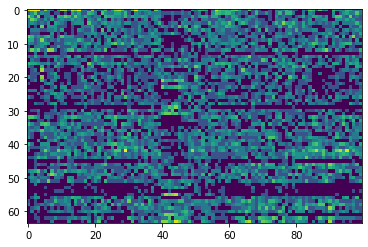

array([[2.5649493, 2.6390574, 2.6390574, ..., 1.0986123, 1.0986123,
        1.0986123],
       [0.6931472, 1.3862944, 1.9459102, ..., 1.0986123, 1.9459102,
        1.0986123],
       [2.3025851, 1.609438 , 0.6931472, ..., 0.6931472, 1.0986123,
        0.6931472],
       ...,
       [0.       , 0.       , 0.6931472, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.6931472, ..., 1.0986123, 0.6931472,
        0.6931472],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [ ]:
get_average_gradient_index(3,histone_inputs,seq_inputs,seq_outputs,model1,model2,model3)

3


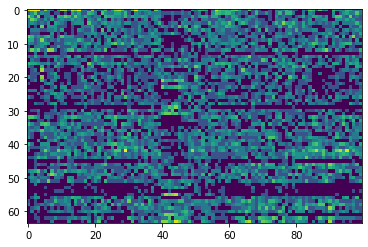

5


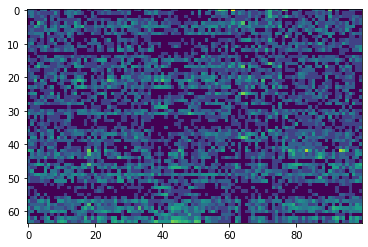

419


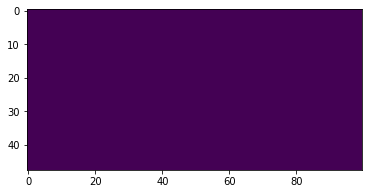

457


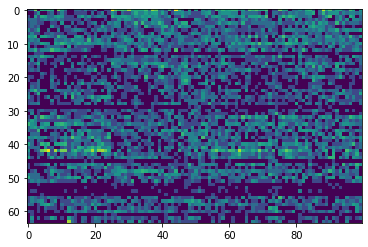

460


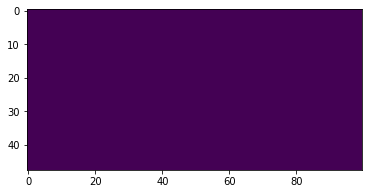

938


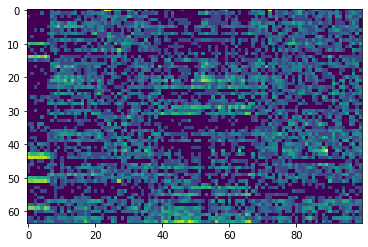

971


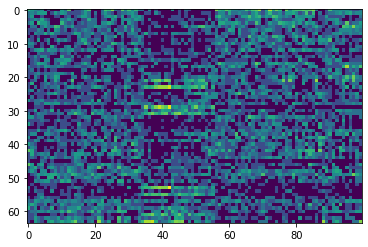

1036


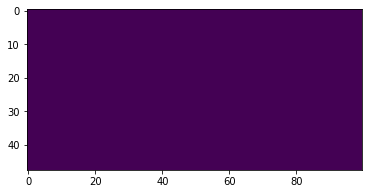

1084


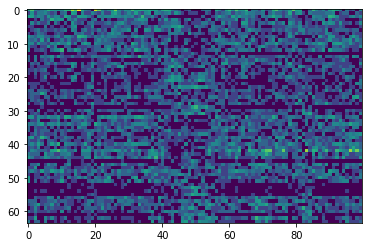

1167


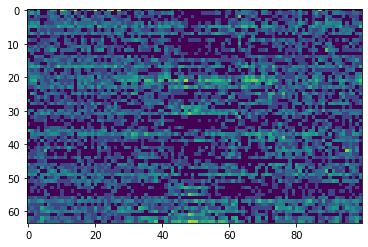

In [ ]:
for i in range(10):
  print(seq_outputs[i].data.numpy()[0])
  get_average_gradient_index(seq_outputs[i].data.numpy()[0],histone_inputs,seq_inputs,seq_outputs,model1,model2,model3)

In [ ]:
histone_inputs.shape

torch.Size([720000, 16, 100])

In [ ]:
histone_outputs.shape

torch.Size([720000])

In [ ]:
seq_inputs.size()

torch.Size([17447, 64, 100])

In [ ]:
seq_outputs.size()

torch.Size([17447, 1])

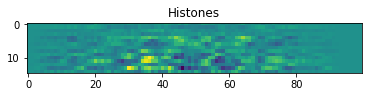

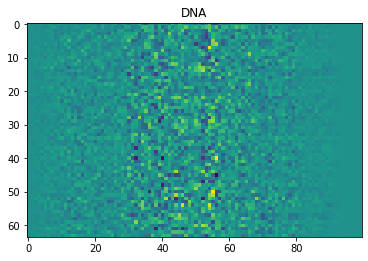

In [ ]:
do_input_grad(model1,real_inputs)

In [ ]:
# get saliency plots of some highly expressed genes
for i in range(1,200):
  if train_outputs[i] > 4.0:
    get_grad_i(Model1,Model2,Model3,train_inputs,train_outputs,i)

AttributeError: ignored

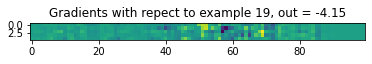

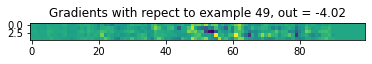

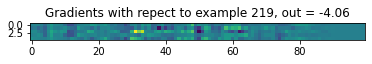

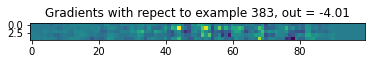

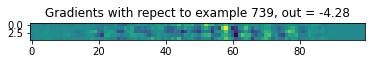

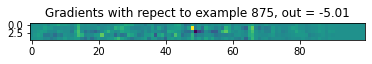

In [ ]:
# get saliency plots of some lowly expressed genes
for i in range(1,1000):
  if train_outputs[i] < -4.0:
    get_grad_i(model1,model2,model3,train_inputs,train_outputs,i)

In [ ]:
# get saliency plots of some highly expressed genes


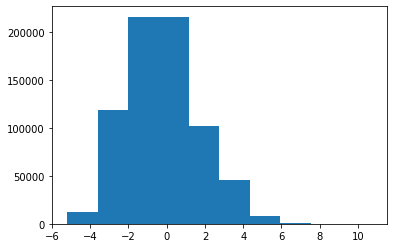

In [ ]:
plt.figure()
plt.hist(train_outputs)
plt.show()

In [ ]:
train_cells = ['E065', 'E004', 'E066', 'E005', 'E012', 'E027', 'E053', 'E013', 'E028', 'E061', 'E109', 'E120', 'E062', 'E037', 'E038', 'E024', 'E105', 'E011', 'E106', 'E082', 'E097', 'E116', 'E098', 'E058',
'E117', 'E059', 'E070', 'E118', 'E085', 'E104', 'E119', 'E006', 'E127', 'E047', 'E094', 'E007', 'E054', 'E128', 'E095', 'E055', 'E114', 'E100', 'E056', 'E016', 'E122', 'E057', 'E123', 'E079', 'E003', 'E050']


def average_high(model1,model2,model3,inputs,outputs,cell_index = 10):
    num_examples = 720000
    num_cells = len(train_cells)
    num_per_cell = num_examples / num_cells
    high_average = np.zeros((5,100))
    low_average = np.zeros((5,100))
    for i in tqdm(range(int(cell_index*num_per_cell),int((cell_index + 1)*num_per_cell))):
        if outputs[i] > 4.0:
          high_average += get_grad_i(model1,model2,model3,inputs,outputs,i,plot=False).numpy()
        if outputs[i] < -4.0:
          low_average += get_grad_i(model1,model2,model3,inputs,outputs,i,plot=False).numpy()

    high_average = high_average / num_per_cell
    low_average = low_average / num_per_cell

    plt.figure()
    plt.title(f'Gradients for highly expressed genes in cell type {train_cells[cell_index]}')
    plt.imshow(high_average)
    plt.show()

    plt.figure()
    plt.title(f'Gradients for lowly expressed genes in cell type {train_cells[cell_index]}')
    plt.imshow(low_average)
    plt.show()

    return high_average, low_average

def average_abs_high(model1,model2,model3,inputs,outputs,cell_index = 10):
    num_examples = 720000
    num_cells = len(train_cells)
    num_per_cell = num_examples / num_cells
    high_average = np.zeros((5,100))
    low_average = np.zeros((5,100))
    for i in tqdm(range(int(cell_index*num_per_cell),int((cell_index + 1)*num_per_cell))):
        if outputs[i] > 4.0:
          high_average += get_abs_grad_i(model1,model2,model3,inputs,outputs,i,plot=False).numpy()
        if outputs[i] < -4.0:
          low_average += get_abs_grad_i(model1,model2,model3,inputs,outputs,i,plot=False).numpy()

    high_average = high_average / num_per_cell
    low_average = low_average / num_per_cell

    plt.figure()
    plt.title(f'Gradients for highly expressed genes in cell type {train_cells[cell_index]}')
    plt.imshow(high_average)
    plt.show()

    plt.figure()
    plt.title(f'Gradients for lowly expressed genes in cell type {train_cells[cell_index]}')
    plt.imshow(low_average)
    plt.show()

    return high_average, low_average

def abs_counts(model1,model2,model3,inputs,outputs,cell_index = 10, thresh = 0.007):
    num_examples = 720000
    num_cells = len(train_cells)
    num_per_cell = num_examples / num_cells
    high_count = np.zeros((5,100))
    low_count = np.zeros((5,100))
    for i in tqdm(range(int(cell_index*num_per_cell),int((cell_index + 1)*num_per_cell))):
        if outputs[i] > 4.0:
          high_count += np.where(get_abs_grad_i(model1,model2,model3,inputs,outputs,i,plot=False).numpy() > thresh, 1, 0)
        if outputs[i] < -4.0:
          low_count += np.where(get_abs_grad_i(model1,model2,model3,inputs,outputs,i,plot=False).numpy() > thresh, 1, 0)

    high_count = high_count / num_per_cell
    low_count = low_count / num_per_cell

    plt.figure()
    plt.title(f'Gradients for highly expressed genes in cell type {train_cells[cell_index]}')
    plt.imshow(high_count)
    plt.show()

    plt.figure()
    plt.title(f'Gradients for lowly expressed genes in cell type {train_cells[cell_index]}')
    plt.imshow(low_count)
    plt.show()

    return high_count, low_count

In [ ]:
train_cells = ['E065', 'E004', 'E066', 'E005', 'E012', 'E027', 'E053', 'E013', 'E028', 'E061', 'E109', 'E120', 'E062', 'E037', 'E038', 'E024', 'E105', 'E011', 'E106', 'E082', 'E097', 'E116', 'E098', 'E058',
'E117', 'E059', 'E070', 'E118', 'E085', 'E104', 'E119', 'E006', 'E127', 'E047', 'E094', 'E007', 'E054', 'E128', 'E095', 'E055', 'E114', 'E100', 'E056', 'E016', 'E122', 'E057', 'E123', 'E079', 'E003', 'E050']
eval_cells = ['E065', 'E004', 'E066', 'E005', 'E012', 'E027', 'E053', 'E013', 'E028', 'E061', 'E109', 'E120', 'E062', 'E037', 'E038', 'E024', 'E071', 'E105', 'E087', 'E011', 'E106', 'E096', 'E082', 'E097',
'E116', 'E098', 'E058', 'E117', 'E084', 'E059', 'E070', 'E118', 'E085', 'E104', 'E119', 'E006', 'E112', 'E127', 'E047', 'E094', 'E007', 'E054', 'E113', 'E128', 'E095', 'E055', 'E114', 'E100', 'E056', 'E016', 'E122', 'E057', 'E123', 'E079', 'E003', 'E050']
len(list(set(train_cells + eval_cells)))

56

Without taking the absolute values ...

100%|██████████| 14400/14400 [01:50<00:00, 130.81it/s]


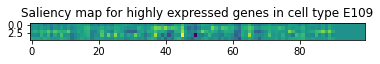

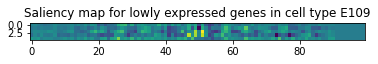

In [ ]:
a,b = average_high(model1,model2,model3,train_inputs,train_outputs,cell_index = 10)

100%|██████████| 14400/14400 [01:44<00:00, 137.61it/s]


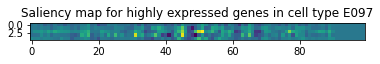

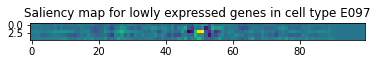

In [ ]:
a,b = average_high(model1,model2,model3,train_inputs,train_outputs,cell_index = 20)

100%|██████████| 14400/14400 [00:38<00:00, 378.67it/s]


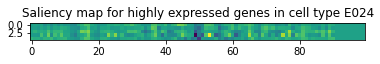

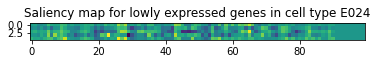

In [ ]:
a,b = average_high(model1,model2,model3,train_inputs,train_outputs,cell_index = 15)

100%|██████████| 14400/14400 [00:26<00:00, 550.72it/s]


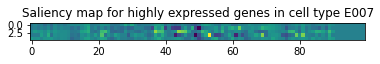

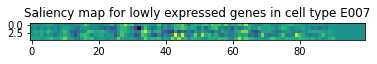

In [ ]:
a,b = average_high(model1,model2,model3,train_inputs,train_outputs,cell_index = 35)

With absolute values ...

100%|██████████| 14400/14400 [00:32<00:00, 440.94it/s]


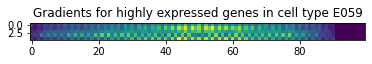

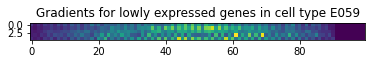

In [ ]:
a,b = average_abs_high(model1,model2,model3,train_inputs,train_outputs,cell_index = 25)

0.011902824809173278


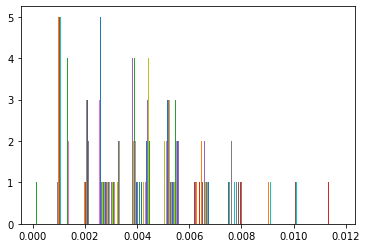

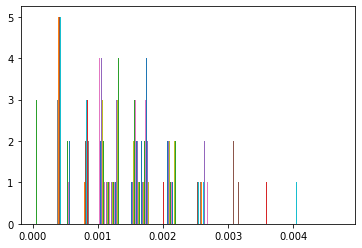

In [ ]:
print(np.max(a))
plt.figure()
plt.hist(a)
plt.show()

plt.figure()
plt.hist(b)
plt.show()

Without absolute values ...

100%|██████████| 14400/14400 [00:43<00:00, 334.24it/s]


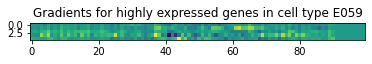

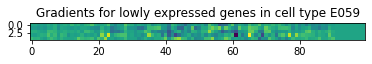

In [ ]:
a,b = average_high(model1,model2,model3,train_inputs,train_outputs,cell_index = 25)

100%|██████████| 14400/14400 [00:32<00:00, 440.53it/s]


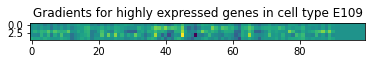

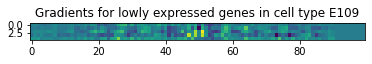

In [ ]:
a,b = average_high(model1,model2,model3,train_inputs,train_outputs,cell_index = 10)

100%|██████████| 14400/14400 [00:24<00:00, 583.94it/s]


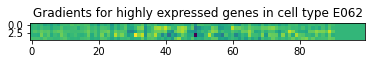

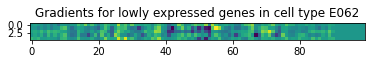

In [ ]:
a,b = average_high(model1,model2,model3,train_inputs,train_outputs,cell_index = 12)

In [ ]:
def just_average(model1,model2,model3,inputs,outputs,cell_index = 10):
    num_examples = 720000
    num_cells = len(train_cells)
    num_per_cell = num_examples / num_cells
    just_avg = np.zeros((5,100))
    for i in range(int(cell_index*num_per_cell),int(cell_index*num_per_cell) + 1000):
        just_avg += get_grad_i(model1,model2,model3,inputs,outputs,i,plot=False).numpy()

    just_avg = just_avg / 1000

    print(train_cells[cell_index])
    plt.figure()
    #plt.title(f'{train_cells[cell_index]}')
    plt.imshow(just_avg)
    plt.show()

    return just_avg


100%|██████████| 1000/1000 [01:03<00:00, 15.81it/s]


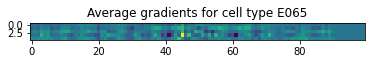


100%|██████████| 1000/1000 [01:03<00:00, 15.66it/s]


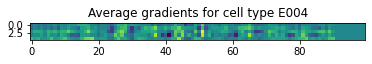


100%|██████████| 1000/1000 [01:04<00:00, 15.46it/s]


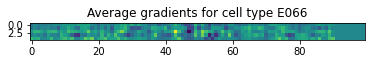


100%|██████████| 1000/1000 [01:04<00:00, 15.47it/s]


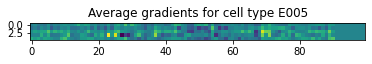


100%|██████████| 1000/1000 [01:05<00:00, 15.32it/s]


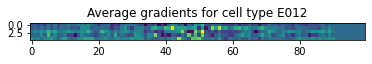


100%|██████████| 1000/1000 [01:05<00:00, 15.31it/s]


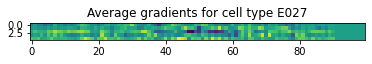


100%|██████████| 1000/1000 [01:04<00:00, 15.41it/s]


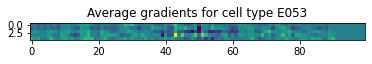


100%|██████████| 1000/1000 [01:05<00:00, 15.28it/s]


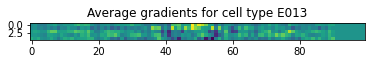


100%|██████████| 1000/1000 [01:05<00:00, 15.32it/s]


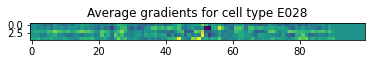


100%|██████████| 1000/1000 [01:06<00:00, 14.96it/s]


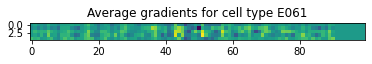

In [ ]:
for i in range(10):
    just_average(model1,model2,model3,train_inputs,train_outputs,cell_index = i)

E065


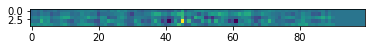

E004


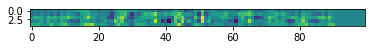

E066


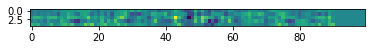

E005


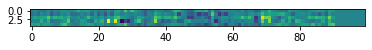

E012


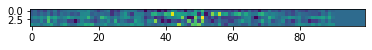

E027


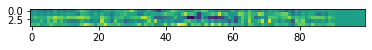

E053


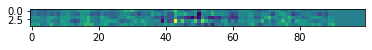

E013


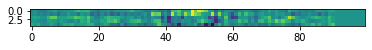

E028


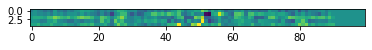

E061


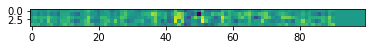

In [ ]:
for i in range(10):
    just_average(model1,model2,model3,train_inputs,train_outputs,cell_index = i)

In [ ]:
def get_maximum_activation(model1, model2, model3, tol = 1e-1, time_step = 1e-5, max_iterations = 500):
  #x = np.zeros((1,80,100), dtype = "float32") + np.float32(np.random.random((1,80,100)))
  x = torch.cat((histone_inputs[0:1,:,:], seq_inputs[0:1,:,:]),1).numpy()
  old_x = np.array(x)
  for i in tqdm(range(max_iterations)):
    torch_x = torch.from_numpy(x)
    torch_x.requires_grad = True
    outp = model1.conv[0](torch_x) - model2.conv[0](torch_x) + model3.conv[0](torch_x)
    outp = torch.sum(outp)
    outp.backward()
    old_x = x
    x = x + time_step*torch_x.grad.numpy()
    if np.sum(np.abs(x - old_x)) < tol:
      break
    
    if i%10 == 0:
      print(f"After {i} iterations")
      print(f"Gene expression value is {outp}")
      plt.figure()
      plt.imshow(x[0,1:,:])
      plt.colorbar()
      plt.show()
   
  print("Finished with gradient descent")
  print(f"Gene expression value is {outp}")
  plt.figure()
  plt.imshow(x[0,1:,:])
  plt.colorbar()
  plt.show()

  return x

def get_average_gradient_index(indy,histone_inputs,seq_inputs,seq_outputs,model1,model2,model3):
  indices = (histone_inputs[:,0,0] == indy).nonzero().numpy()[:,0]
  avg_grad = np.zeros((64,100))
  inpp = torch.zeros([1,64,100],dtype=float)
  #inpp.requires_grad = True
  #inpp.grad.data.zero_()
  for i in indices: 
    #inp = torch.cat((histone_inputs[i,:,:],seq_inputs[i,:,:]),0).view((1,80,100))
    inpp = torch.cat((histone_inputs[i,:,:],seq_inputs[indy,:,:]),0).view((1,80,100))
    get_three_input_grad(model1,model2,model3,inpp)
  res = inpp.detach().numpy()[0,16:,:]
  inpp.grad.data.zero_()
  plt.figure()
  plt.imshow(res)
  #plt.colorbar()
  plt.show()
  return res

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


After 0 iterations
Gene expression value is 20801.5625


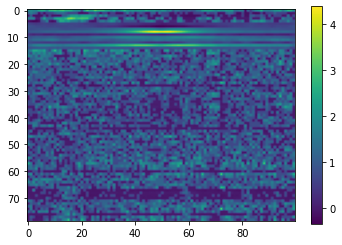

After 10 iterations
Gene expression value is 1216786.875


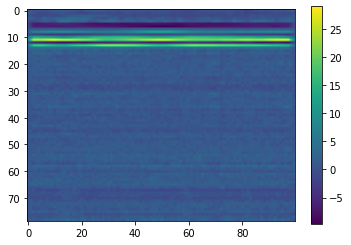

After 20 iterations
Gene expression value is 2571772.5


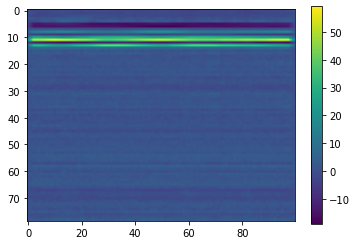

After 30 iterations
Gene expression value is 3940236.0


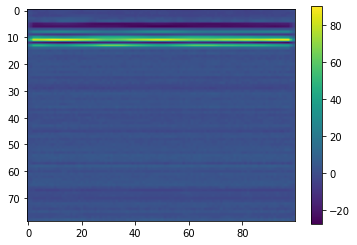

After 40 iterations
Gene expression value is 5315820.0


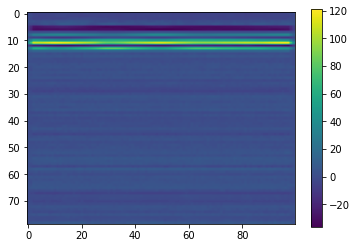

After 50 iterations
Gene expression value is 6695855.0


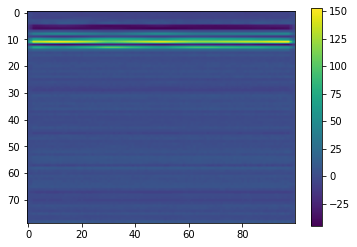

After 60 iterations
Gene expression value is 8079215.0


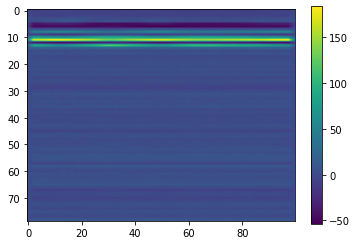

After 70 iterations
Gene expression value is 9465274.0


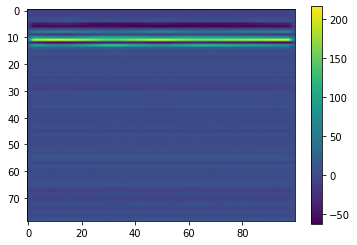

After 80 iterations
Gene expression value is 10853303.0


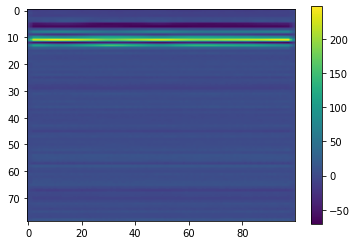

After 90 iterations
Gene expression value is 12242947.0


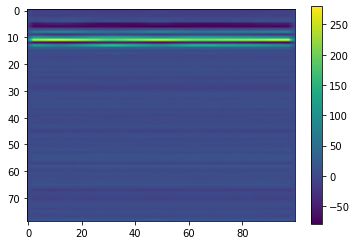

After 100 iterations
Gene expression value is 13634062.0


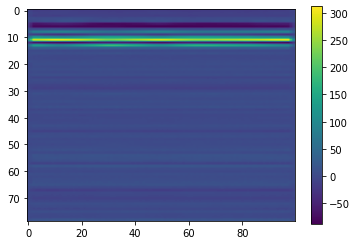

After 110 iterations
Gene expression value is 15026359.0


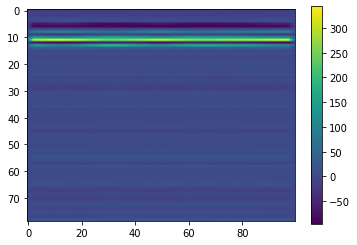

After 120 iterations
Gene expression value is 16419807.0


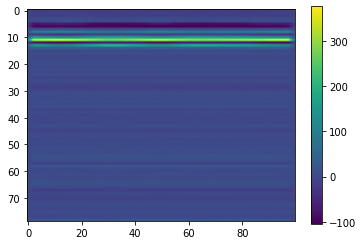

After 130 iterations
Gene expression value is 17814132.0


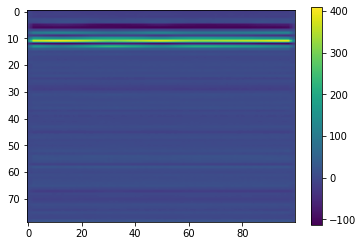

After 140 iterations
Gene expression value is 19209464.0


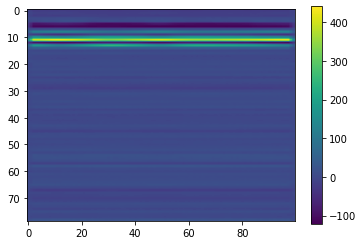

After 150 iterations
Gene expression value is 20605538.0


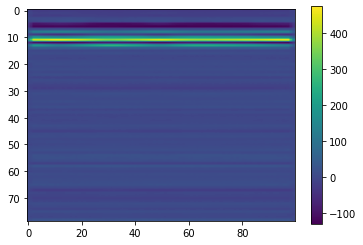

After 160 iterations
Gene expression value is 22002364.0


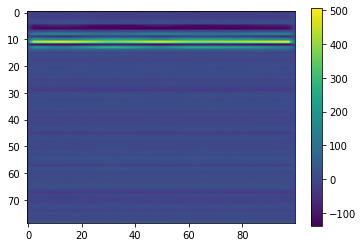

After 170 iterations
Gene expression value is 23399796.0


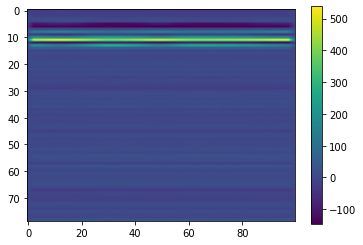

After 180 iterations
Gene expression value is 24797788.0


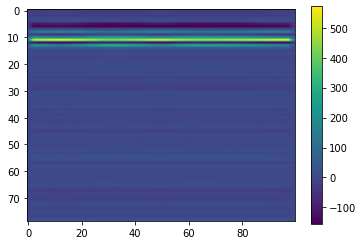

After 190 iterations
Gene expression value is 26196464.0


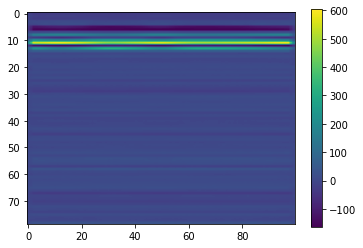

After 200 iterations
Gene expression value is 27595830.0


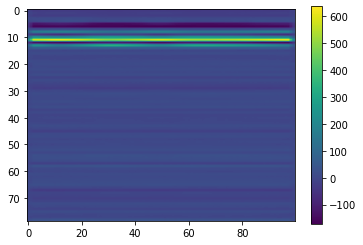

After 210 iterations
Gene expression value is 28995778.0


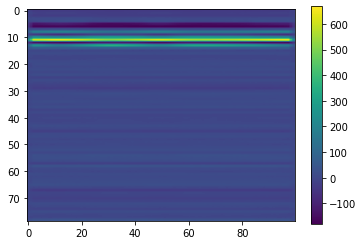

KeyboardInterrupt: ignored

In [ ]:
get_maximum_activation(model1,model2,model3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


After 0 iterations
Gene expression value is 7859.9052734375


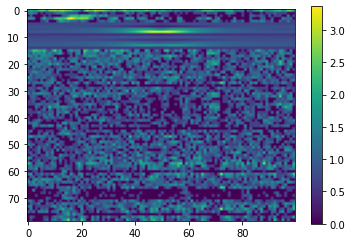

After 10 iterations
Gene expression value is 7949.716796875


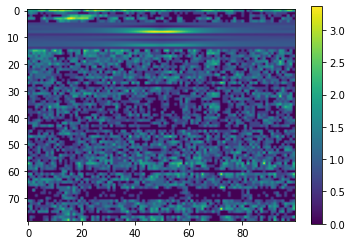

After 20 iterations
Gene expression value is 8040.37060546875


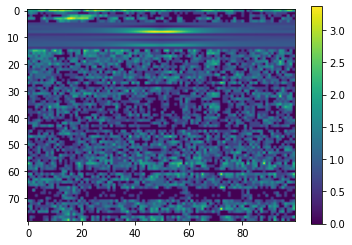

After 30 iterations
Gene expression value is 8131.72314453125


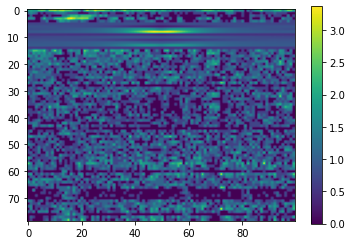

After 40 iterations
Gene expression value is 8224.2919921875


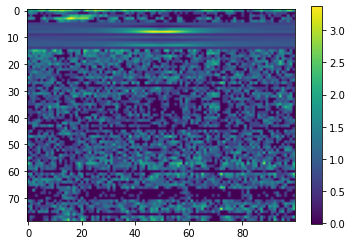

After 50 iterations
Gene expression value is 8318.1083984375


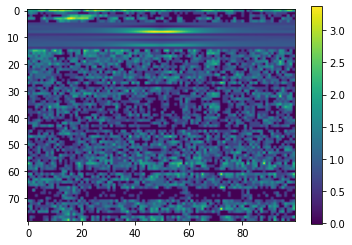

After 60 iterations
Gene expression value is 8413.1083984375


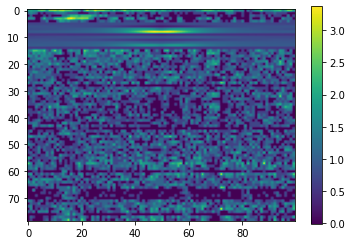

After 70 iterations
Gene expression value is 8509.4970703125


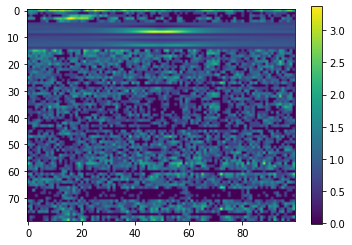

After 80 iterations
Gene expression value is 8607.4189453125


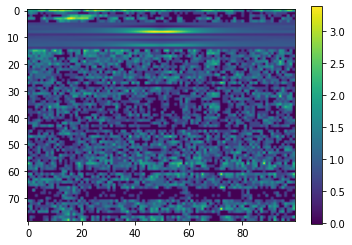

After 90 iterations
Gene expression value is 8706.572265625


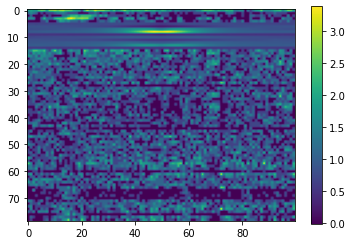

After 100 iterations
Gene expression value is 8807.033203125


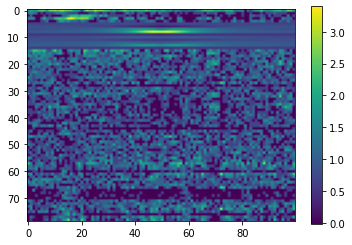

After 110 iterations
Gene expression value is 8908.5693359375


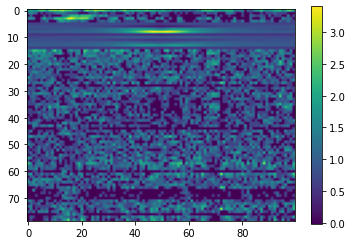

After 120 iterations
Gene expression value is 9011.4130859375


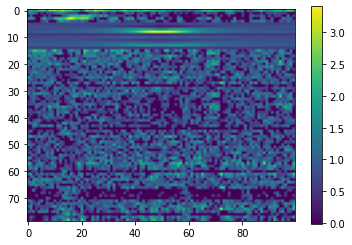

After 130 iterations
Gene expression value is 9115.671875


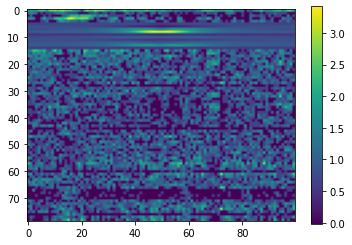

After 140 iterations
Gene expression value is 9221.1513671875


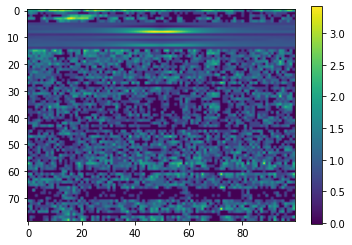

After 150 iterations
Gene expression value is 9327.580078125


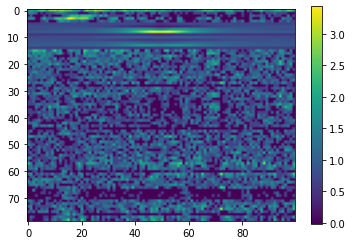

After 160 iterations
Gene expression value is 9435.0244140625


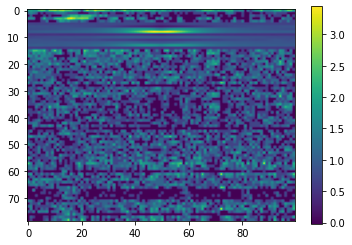

After 170 iterations
Gene expression value is 9543.6650390625


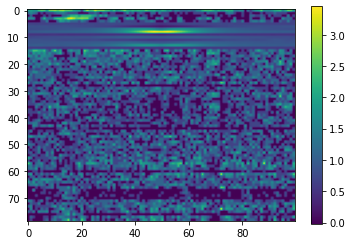

After 180 iterations
Gene expression value is 9653.470703125


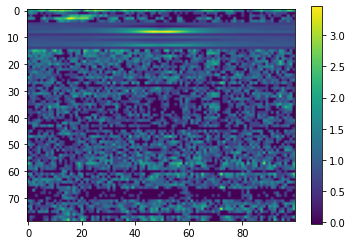

After 190 iterations
Gene expression value is 9764.5126953125


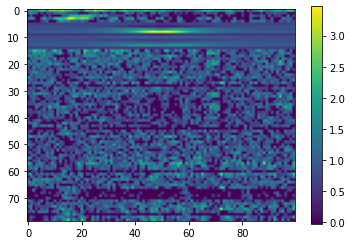

After 200 iterations
Gene expression value is 9876.5


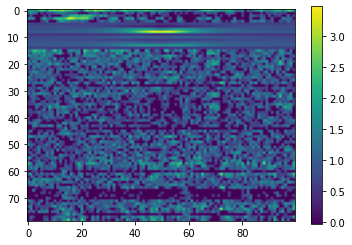

After 210 iterations
Gene expression value is 9989.787109375


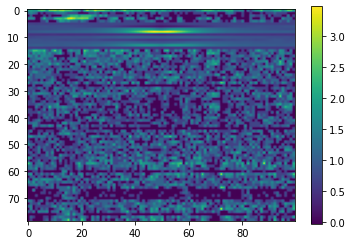

After 220 iterations
Gene expression value is 10104.3798828125


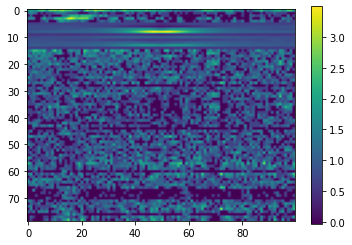

After 230 iterations
Gene expression value is 10220.15625


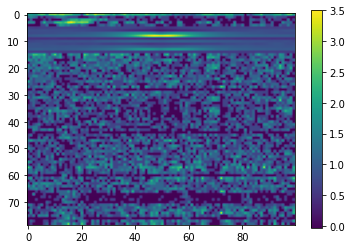

After 240 iterations
Gene expression value is 10337.0126953125


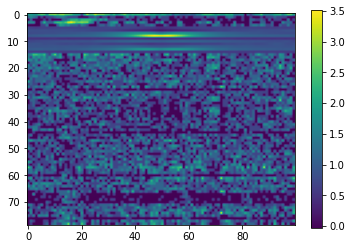

After 250 iterations
Gene expression value is 10455.0146484375


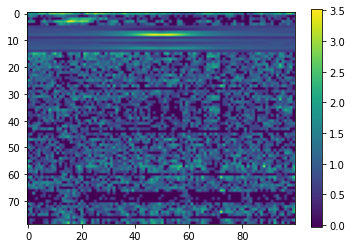

After 260 iterations
Gene expression value is 10574.2978515625


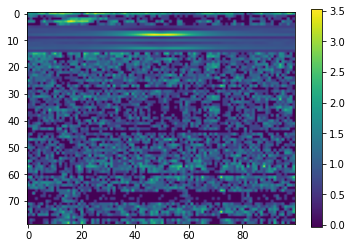

After 270 iterations
Gene expression value is 10694.8525390625


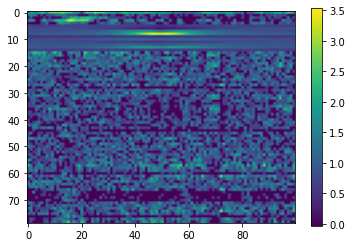

After 280 iterations
Gene expression value is 10816.744140625


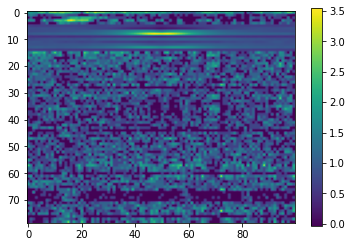

After 290 iterations
Gene expression value is 10940.1806640625


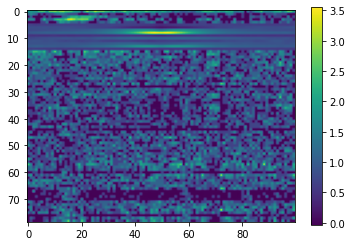

After 300 iterations
Gene expression value is 11064.8125


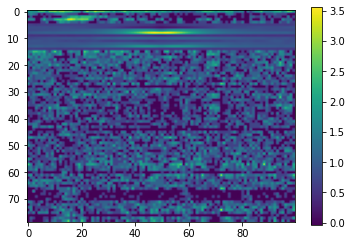

After 310 iterations
Gene expression value is 11190.3408203125


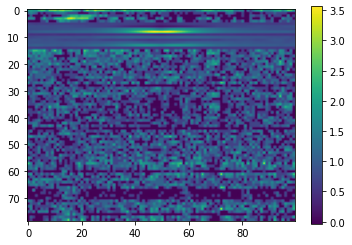

After 320 iterations
Gene expression value is 11317.1298828125


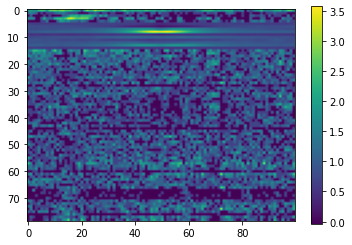

After 330 iterations
Gene expression value is 11445.12890625


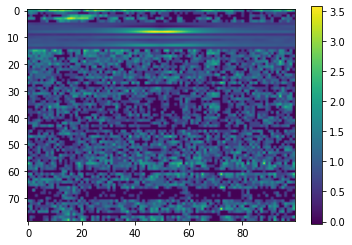

After 340 iterations
Gene expression value is 11574.1279296875


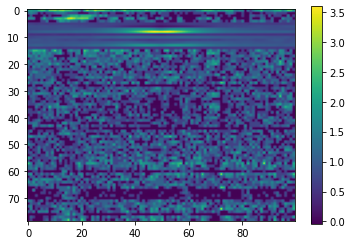

After 350 iterations
Gene expression value is 11704.2890625


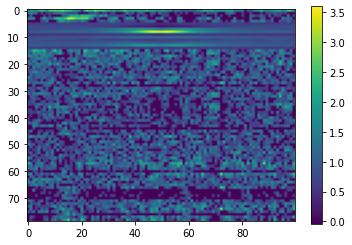

After 360 iterations
Gene expression value is 11835.8984375


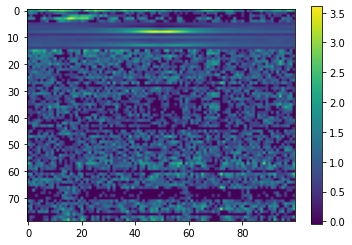

After 370 iterations
Gene expression value is 11968.6796875


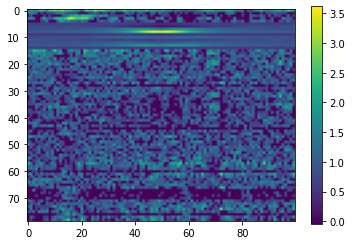

KeyboardInterrupt: ignored

In [ ]:
best_one = get_maximum_activation(model1,model2,model3,time_step = 1e-5,tol = 1e-5,max_iterations = 500)